In [1]:
import PIL
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.functional import F


import torchvision
from torchvision.ops import nms
from torchvision.ops import RoIPool

from torchvision.ops import boxes as box_ops

import pandas as pd
import os
from tqdm.notebook import trange, tqdm
import cv2

from model import CenterNet

import matplotlib.pyplot as plt

In [2]:
use_cuda = True
device = torch.device('cuda:4' if use_cuda else 'cpu')
x = torch.Tensor([0]).cuda(device)

In [3]:
# dataset的路径
path = '../data/car-object-detection/data/'

In [4]:
'''
    image file name: array([bbox1,bbox2])
'''
train_bbox_pd = pd.read_csv(path + 'train_solution_bounding_boxes.csv')
train_bbox_np = train_bbox_pd.to_numpy()
train_bbox = {}
for d in train_bbox_np:
    if d[0] not in train_bbox:
        train_bbox.update({d[0]:[d[1:]]})
    else:
        train_bbox[d[0]].append(d[1:])
train_bbox = {d:np.array(train_bbox[d]) for d in train_bbox}

In [5]:
# dataset的路径
path = '../data/car-object-detection/data/'
train_imagefile = [i for i in os.listdir(path + 'training_images') if i[-3:] == 'jpg']
test_imagefile = [i for i in os.listdir(path + 'testing_images') if i[-3:] == 'jpg']

In [6]:
class cardset(torch.utils.data.Dataset):
    def __init__(self, path = '../data/car-object-detection/data/'):
        super(cardset, self).__init__()
        self.path = path
        # 读取图像文件名
        self.train_imagefile = [i for i in os.listdir(path + 'training_images') if i[-3:] == 'jpg']
        self.test_imagefile = [i for i in os.listdir(path + 'testing_images') if i[-3:] == 'jpg']
        self.train_img = []
        self.test_img = []
        # 读取训练集的bbox
        train_bbox_pd = pd.read_csv(self.path + 'train_solution_bounding_boxes.csv')
        self.train_bbox_np = train_bbox_pd.to_numpy()
        self.train_bbox = {}
        self.idx2file = {}
        self.file2idx = {}
        i = 0
        for d in self.train_bbox_np:
            if d[0] not in self.train_bbox:
                self.train_bbox.update({d[0]:[d[1:]]})
                self.idx2file.update({i:d[0]})
                self.file2idx.update({d[0]:i})
                i += 1
            else:
                self.train_bbox[d[0]].append(d[1:])
        self.train_bbox = {d:np.array(self.train_bbox[d],dtype = np.float32) for d in self.train_bbox}
        # 读取数据到内存
        for filename in tqdm(self.train_imagefile,desc = 'Reading train data'):
            img = Image.open(path + 'training_images/' + filename)
            self.train_img.append([filename,img])
            if filename not in self.train_bbox:
                self.train_bbox.update({filename:[]})
                self.idx2file.update({i:filename})
                self.file2idx.update({filename:i})
                i += 1
                
        for filename in tqdm(self.test_imagefile,desc = 'Reading test data'):
            img = Image.open(path + 'testing_images/' + filename)
            self.test_img.append([filename,img])
            
    def __getitem__(self, index):
        if isinstance(self.train_img[index][1],(Image.Image)):
            self.train_img[index][1] = torchvision.transforms.functional.pil_to_tensor(self.train_img[index][1])/255
        img = self.train_img[index][1]
#         print(self.train_bbox[self.train_img[index][0]])
        label_num = self.file2idx[self.train_img[index][0]]
        return img, label_num
    
    def __len__(self):
        return len(self.train_img)

In [7]:
car = cardset()

Reading train data:   0%|          | 0/1001 [00:00<?, ?it/s]

Reading test data:   0%|          | 0/175 [00:00<?, ?it/s]

In [8]:
def collect(batch):
    img,label_num = [i for i in zip(*batch)]
    img = torch.stack(img,0)
    label_num = torch.Tensor(label_num)
    return img,label_num
car_dataloader = torch.utils.data.DataLoader(car, batch_size = 8, shuffle = True,collate_fn = collect,drop_last = True)

In [9]:
# myiter = tqdm(car_dataloader,colour = '#0066FF')
# myiter.set_description_str('car dataloader')
# for x,y in myiter:
#     pass

In [10]:
def getTarget(x,y):
    target = []
    for i in y:
        t = car.train_bbox[car.idx2file[int(i)]]
        shape = len(t)
        label = 1
        if len(t) == 0:
            t = [[0,0,x.shape[-1]-1,x.shape[-2]-1]]
            shape = 1
            label = 0
        target.append({'bboxes':torch.Tensor(t).cuda(device), 'classes': torch.from_numpy(np.zeros(shape, dtype = np.int64) + label).cuda(device)})
    return target

In [11]:
# target = getTarget(x,y)

# model

In [12]:
centerNet = CenterNet(2)
centerNet.to(device)
centerNet.mode

'train'

In [13]:
x = x.cuda(device)

In [14]:
# result, losses = centerNet(x,target)

In [15]:
centerNet = torch.load('model/centerNet3.pt')
centerNet.to(device)
optimizer = optim.Adam(centerNet.parameters(),5e-4)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

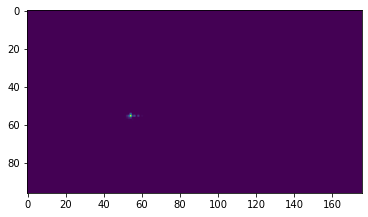

  0%|          | 0/125 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
centerNet.train()
centerNet.mode = 'train'
min_loss = 1e9
for epoch in trange(70):
    myiter = tqdm(car_dataloader,colour = '#0066FF')
    myiter.set_description_str('car dataloader')
    all_loss = 0
    for x,y in myiter:
        x = x.cuda(device)
        target = getTarget(x,y)
        result, losses = centerNet(x,target)

        optimizer.zero_grad()
        loss = losses['point_focal_loss'] + 0.1*losses['size_loss'] + losses['offset_loss']
        loss.backward()
        optimizer.step()
        all_loss += float(loss)
        myiter.set_postfix(epoch = epoch,loss = float(loss),focal_loss = float(losses['point_focal_loss']),
                           size_loss = float(losses['size_loss']),
                           offset_loss = float(losses['offset_loss']),all_loss = all_loss)
        
        
    if all_loss < min_loss:
        min_loss = all_loss
        torch.save(centerNet, 'model/centerNet2.pt')
        plt.imshow(losses['heatmap'][0][1].detach().cpu())
        plt.show()
#         plt.imshow(losses['gt_hm'][0][1].detach().cpu())
#         plt.show()

In [ ]:
class focal_loss(nn.Module):
    def __init__(self, alpha = 2, beta = 4, reduction = 'sum', N = 1):
        super(focal_loss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.reduction = 'sum'
        self.N = N
        
    def forward(self, pred_hm, gt_hm):
        focalLoss = 0
        pred_hm = torch.clamp(pred_hm, 1e-6, 1-1e-6)
        pos_idx = (gt_hm == 1)
        neg_idx = (gt_hm != 1)
        # positive focal loss
        focalLoss += torch.sum((1 - pred_hm[pos_idx]).pow(self.alpha)*torch.log(pred_hm[pos_idx]))
        # negative
        focalLoss += torch.sum((1 - gt_hm[neg_idx]).pow(self.beta)*pred_hm[neg_idx].pow(self.alpha)*torch.log(1 - pred_hm[neg_idx]))
        if self.reduction == 'sum':
            return -focalLoss
        else:
            return -focalLoss/self.N

In [18]:
x,y = iter(car_dataloader).next()
x = x.cuda(device)
target = getTarget(x,y)
target

[{'bboxes': tensor([[  0.,   0., 675., 379.]], device='cuda:4'),
  'classes': tensor([0], device='cuda:4')},
 {'bboxes': tensor([[100.2750, 192.9038, 169.7337, 225.6709],
          [531.2127, 173.8304, 626.1071, 209.0428]], device='cuda:4'),
  'classes': tensor([1, 1], device='cuda:4')},
 {'bboxes': tensor([[  0.,   0., 675., 379.]], device='cuda:4'),
  'classes': tensor([0], device='cuda:4')},
 {'bboxes': tensor([[ 16.1418, 194.8600,  92.4486, 229.5833],
          [  0.0000, 202.6850,  48.9146, 238.3864],
          [290.5528, 188.9913, 389.8495, 230.0724],
          [605.0738, 176.2757, 676.0000, 218.3349]], device='cuda:4'),
  'classes': tensor([1, 1, 1, 1], device='cuda:4')},
 {'bboxes': tensor([[  0.,   0., 675., 379.]], device='cuda:4'),
  'classes': tensor([0], device='cuda:4')},
 {'bboxes': tensor([[  0.,   0., 675., 379.]], device='cuda:4'),
  'classes': tensor([0], device='cuda:4')},
 {'bboxes': tensor([[  0.,   0., 675., 379.]], device='cuda:4'),
  'classes': tensor([0], devi

In [19]:
#  centerNet = CenterNet(2)
# centerNet.to(device)
# centerNet.mode
x = x[3:4].cuda(device)
target = getTarget(x,y[3:4])

In [20]:
target

[{'bboxes': tensor([[ 16.1418, 194.8600,  92.4486, 229.5833],
          [  0.0000, 202.6850,  48.9146, 238.3864],
          [290.5528, 188.9913, 389.8495, 230.0724],
          [605.0738, 176.2757, 676.0000, 218.3349]], device='cuda:4'),
  'classes': tensor([1, 1, 1, 1], device='cuda:4')}]

In [21]:
fl = focal_loss(2,4,reduction='mean',N = 3)

NameError: name 'focal_loss' is not defined

In [ ]:
optimizer = optim.AdamW(centerNet.parameters(),5e-4)

In [ ]:
losses['pred_sz']

In [ ]:
losses['size_loss']

In [22]:
for i in range(1):
    result, losses = centerNet(x,target)
#     pred_hm = losses['heatmap']
#     gt_hm = losses['gt_hm']
#     pred_sz = losses['pred_sz']
#     gt_sz = losses['gt_sz']
#     loss = fl(pred_hm, gt_hm)

#     loss = F.mse_loss(pred_hm,gt_hm)
    loss = losses['size_loss']
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(loss)
# print(pred_sz)
# print(gt_sz)

tensor(0.0016, device='cuda:4', grad_fn=<DivBackward0>)


In [23]:
result[0]['scores'].max(),result[0]['scores'].argmax()

(tensor(0.6195, device='cuda:4'), tensor(482, device='cuda:4'))

In [24]:
result[0]['bboxes'][1031]

IndexError: index 1031 is out of bounds for dimension 0 with size 1015

In [25]:
target

[{'bboxes': tensor([[ 16.1418, 194.8600,  92.4486, 229.5833],
          [  0.0000, 202.6850,  48.9146, 238.3864],
          [290.5528, 188.9913, 389.8495, 230.0724],
          [605.0738, 176.2757, 676.0000, 218.3349]], device='cuda:4'),
  'classes': tensor([1, 1, 1, 1], device='cuda:4')}]

In [26]:
result[0]['scores'].argmax(),result[0]['scores'].max()

(tensor(482, device='cuda:4'), tensor(0.6195, device='cuda:4'))

In [27]:
result[0]['bboxes'][result[0]['scores']>0.2]

tensor([[614.9004, 182.7614, 666.1306, 202.4800],
        [623.1950, 181.7909, 673.7276, 203.2563],
        [ 16.9098, 190.4002,  96.0672, 226.5909],
        [ 31.7749, 194.3944,  97.1277, 222.5384],
        [  0.0000, 198.3699,  64.2678, 234.7412],
        [  0.0000, 197.4312,  75.8629, 235.5471]], device='cuda:4')

In [28]:
result[0]['scores'][result[0]['scores']>0.2]

tensor([0.6195, 0.4500, 0.6128, 0.2580, 0.3509, 0.2139], device='cuda:4')

In [29]:
x.shape

torch.Size([1, 3, 380, 676])

In [30]:
def drawbbox(img, pre, keep = None, color = '#FF4565'):
    img1 = img.copy()
    ImageD = ImageDraw.Draw(img1)
    for i in range(len(pre['bboxes'])):
        if keep is not None and i not in keep:
            continue
        box = pre['bboxes'][i]
        ImageD.rectangle([(box[0],box[1]),box[2],box[3]],outline= color,width = 2)
        score = pre['scores'][i]
        ImageD.text((box[0],box[1]),'car:{score:.3f}'.format(score=score),fill = '#FFFFFF')
    return img1

In [31]:
torch.unsqueeze(x,0).shape

torch.Size([1, 1, 3, 380, 676])

In [39]:
img = car.test_img[1][1]
x = torch.unsqueeze(torchvision.transforms.F.pil_to_tensor(img)/255,0).cuda(device)
centerNet.eval()
centerNet.mode = 'test'
result, losses = centerNet(x)

In [40]:
img_array = x[0].permute(1,2,0).cpu().numpy()

In [41]:
img = PIL.Image.fromarray((img_array*255).astype(np.uint8))

In [42]:
keep = np.where(result[0]['scores'].cpu()>0.1)[0]
keep

array([203])

In [43]:
t = target[0]
t['scores'] = np.zeros(len(t['classes'])) + 1
t

{'bboxes': tensor([[ 16.1418, 194.8600,  92.4486, 229.5833],
         [  0.0000, 202.6850,  48.9146, 238.3864],
         [290.5528, 188.9913, 389.8495, 230.0724],
         [605.0738, 176.2757, 676.0000, 218.3349]], device='cuda:4'),
 'classes': tensor([1, 1, 1, 1], device='cuda:4'),
 'scores': array([1., 1., 1., 1.])}

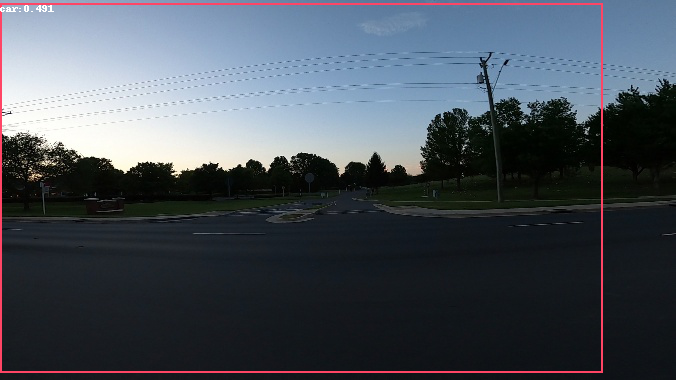

In [44]:
img1 = drawbbox(img, result[0],keep)
# drawbbox(img1, target[0],color = '#00FF00')
img1

In [ ]:
target[5]

In [ ]:
plt.imshow(losses['heatmap'][5][1].detach().cpu())

In [ ]:
plt.imshow(losses['gt_hm'][5][1].detach().cpu())

In [ ]:
losses

In [ ]:
centerNet.eval()
centerNet.mode = 'test'
y,l = centerNet(x)

In [ ]:
y[1]['scores']

In [ ]:
y[2]['scores'].argmax()

In [ ]:
y[2]['scores'][y[2]['scores'].argmax()]

In [ ]:
y[2]['bboxes'][1764]

In [ ]:
y[2]

In [ ]:
target

In [ ]:
result[0]['bboxes'][:,[1,0]]

In [ ]:
torch.mean(losses['heatmap'])